In [2067]:
import cv2
from matplotlib import pyplot as plt
import numpy as np

In [2068]:
original = cv2.imread('images/00000006_000.png')
original = cv2.cvtColor(original, cv2.COLOR_BGR2RGB)

In [2069]:
"""
This step helps to improve certain parameters of CXR images (e.g. the signal-to-noise ratio) and to enhance the visual appearance by removing the irrelevant noise and undesired parts of background

The most commonly encountered types of noise are Salt and Pepper, Speckle, Gaussian, and Poisson noises. Taking into account possible variants of noises on CXR images median filter was selected as the main filter for noise suppression
"""

def remove_noise(image):
    return cv2.medianBlur(image, 5)

In [2070]:
"""
Apart from noise suppression, during medical image processing, the contrast enhancement is required for the area of interest. In proposed methodology we use approach based on BCET. The choice was made because the contrast of the image can be stretched or compressed without changing the histogram pattern of the input image. Also, the other choice is contrast limited adaptive histogram equalization (CLAHE)
"""

def enhance_contrast(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8, 8))
    cl = clahe.apply(l)
    limg = cv2.merge((cl, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

def bcet_transform(image):
    lab = cv2.cvtColor(image, cv2.COLOR_RGB2LAB)
    l, a, b = cv2.split(lab)
    equ = cv2.equalizeHist(l)
    limg = cv2.merge((equ, a, b))
    return cv2.cvtColor(limg, cv2.COLOR_LAB2RGB)

In [2071]:
"""
Discontinuity-Based Approach
This approach focuses on identifying isolated points, lines, or edges in an image. For example, in chest X-ray (CXR) images, this method is used to identify lung boundaries. Edge detection, a fundamental step in this approach, captures the geometric features crucial for outlining lung contours.
"""

def similarity_based(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY) 
    _, thresh = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    return thresh

In [2072]:
def draw_horizontal_lines(img_bin):
    right = 0
    left = 0
    line_thickness = 2
    
    # This is the value that specifies how bright a row is to consider it 'not the edge (too bright)'
    intensity_threshold = 200
    
    # Start at the bottom and work upwards checking the mean of pixels in every 10th row, this is the right side of the image
    for i in range(img_bin.shape[0]-1,0,-10):
        row_mean = img_bin[i].mean()
        if row_mean > intensity_threshold:
            right = i
            
            # Draw a line where we want to crop
            cv2.line(img_bin, (0, i), (img_bin.shape[1], i), (0, img_bin.shape[1], 0), thickness=line_thickness)
            break
            
    # Start at the top and go down to find the left side
    for i in range(0,img_bin.shape[0]-1,10):
        row_mean = img_bin[i].mean()
        if row_mean > intensity_threshold:
            left = i
            
            # Draw a line where we want to crop
            cv2.line(img_bin, (0, i), (img_bin.shape[1], i), (0, img_bin.shape[1], 0), thickness=line_thickness)
            break

    return img_bin, right, left

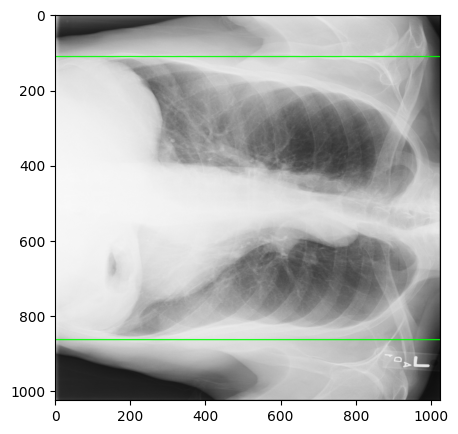

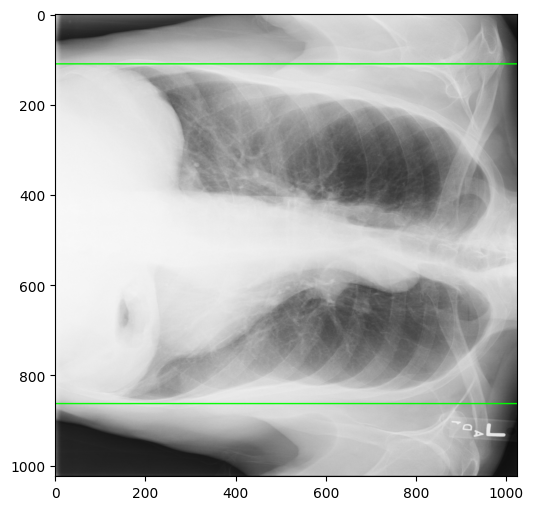

In [2073]:
img_bin = cv2.rotate(original, cv2.ROTATE_90_CLOCKWISE)
drawn_lines, right, left = draw_horizontal_lines(img_bin)

plt.figure(figsize=(15,5))
plt.imshow(img_bin,cmap="gray")
plt.figure(figsize=(12, 6))
plt.imshow(drawn_lines, cmap='gray')

In [2074]:
def crop_image(image, x1, x2, y1, y2):
    return image[x1:x2, y1:y2]

cropped = crop_image(img_bin, left, right, 0, img_bin.shape[1])
img_bin = cv2.rotate(cropped, cv2.ROTATE_90_COUNTERCLOCKWISE)

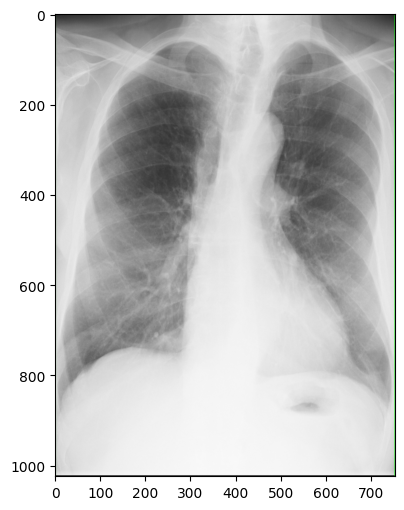

In [2075]:
plt.figure(figsize=(12, 6))
plt.imshow(img_bin, cmap='gray')

In [2076]:
def draw_vertical_lines(img_cropped):
    line_thickness = 5
    top = 0
    bottom = 0
    
    # Set some threshold values to specify what we consider edge vs patient
    bright_threshold = 237
    dark_threshold = 150
    
    # Start at the bottom and work upward
    for i in range(img_cropped.shape[0]-1,0,-10):
        row_mean = img_cropped[i].mean()
        if i == 1023:
            continue
        # print(i, row_mean, 'bottom')
        if row_mean < bright_threshold:
            bottom = i
            cv2.line(img_cropped, (0, i), (img_cropped.shape[1], i), (0, img_cropped.shape[1], 0), thickness=line_thickness)
            print(i, row_mean, 'bottom')
            break
            
    # Start at the top and go down
    for i in range(0,img_cropped.shape[0]-1,10):
        row_mean = img_cropped[i].mean()
        if row_mean > dark_threshold:
            top = i
            cv2.line(img_cropped, (0, i), (img_cropped.shape[1], i), (0, img_cropped.shape[1], 0), thickness=line_thickness)
            print(i, row_mean, 'top')
            break
    
    return img_cropped, top, bottom

933 236.96547144754317 bottom
40 157.70517928286853 top


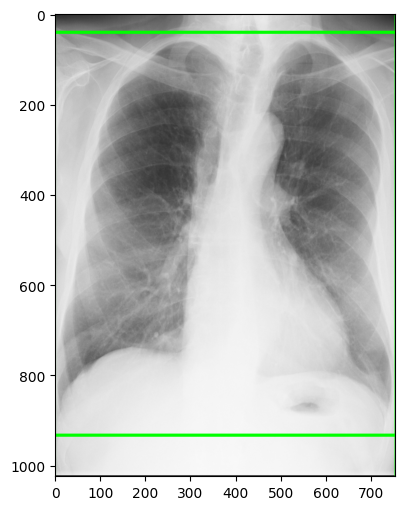

In [2077]:
draw_horizontal, top, bottom = draw_vertical_lines(img_bin)
plt.figure(figsize=(12, 6))
plt.imshow(draw_horizontal, cmap='gray')

In [2078]:
def crop_image_top(image, x1, x2, y1, y2):
    return image[x1:x2, y1:y2]

cropped_top = crop_image_top(draw_horizontal, top, bottom, 0, draw_horizontal.shape[1])
cropped_top = cv2.cvtColor(cropped_top, cv2.COLOR_BGR2RGB)

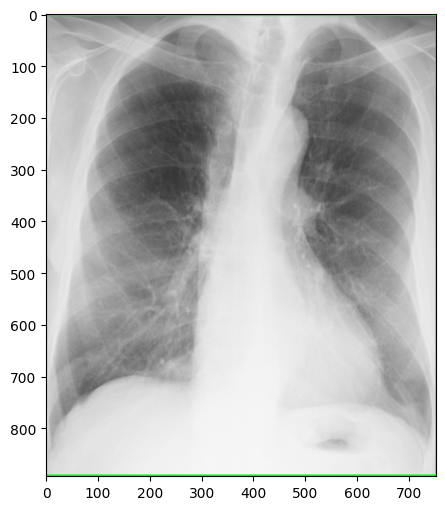

In [2079]:
plt.figure(figsize=(12, 6))
plt.imshow(cropped_top)

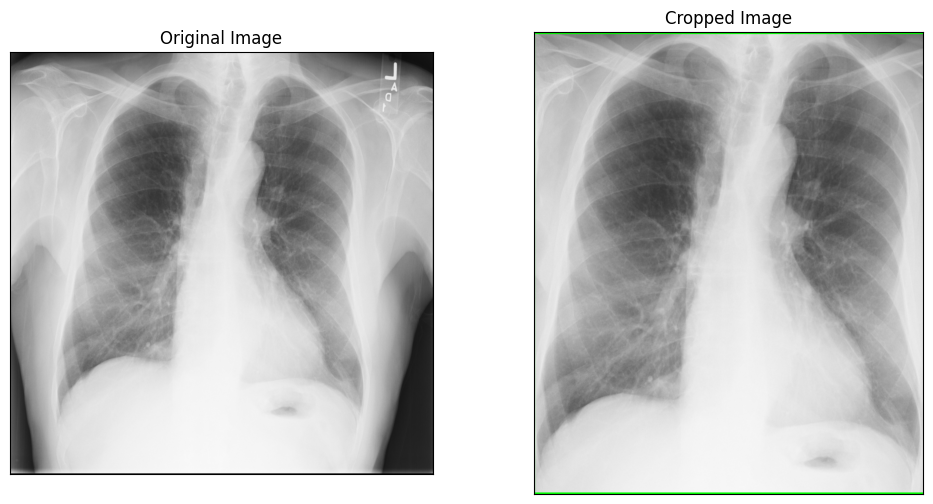

In [2080]:
plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(original)
plt.title('Original Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(cropped_top)
plt.title('Cropped Image'), plt.xticks([]), plt.yticks([])
plt.show()

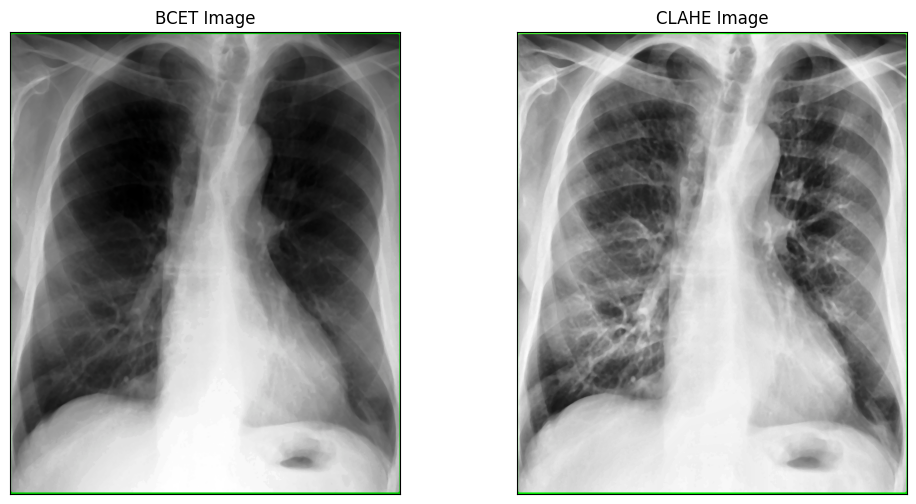

In [2081]:
median = remove_noise(cropped_top)
bcet_result = bcet_transform(median)
clahe_result = enhance_contrast(median)

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(bcet_result)
plt.title('BCET Image'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(clahe_result)
plt.title('CLAHE Image'), plt.xticks([]), plt.yticks([])
plt.show()

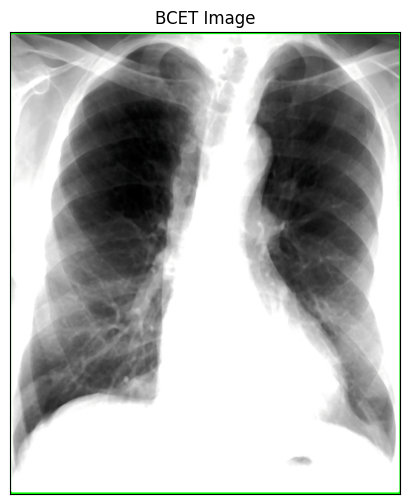

In [2082]:
# increase the contrast of bcet image
bcet_result = cv2.convertScaleAbs(bcet_result, alpha=1.7, beta=0)
plt.figure(figsize=(12, 6))
plt.imshow(bcet_result, cmap='gray')
plt.title('BCET Image'), plt.xticks([]), plt.yticks([])
plt.show()

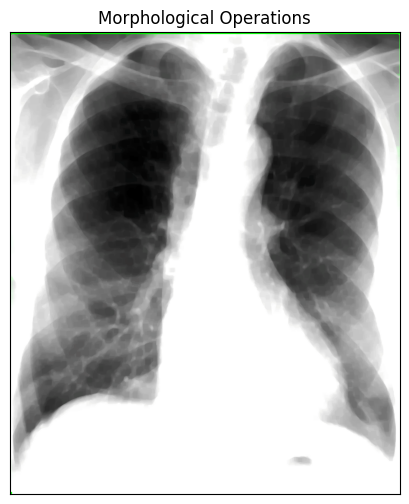

In [2086]:
# morphological operations
kernel = np.ones((3, 3), np.uint8)
closing = cv2.morphologyEx(bcet_result, cv2.MORPH_CLOSE, kernel, iterations=3)
plt.figure(figsize=(12, 6))
plt.imshow(closing, cmap='gray')
plt.title('Morphological Operations'), plt.xticks([]), plt.yticks([])
plt.show()

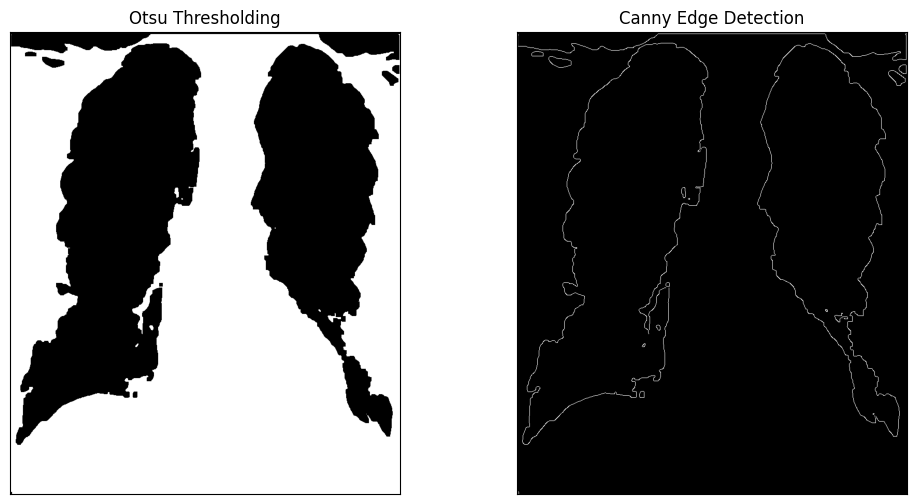

In [2087]:
# otsu thresholding
def otsu_thresholding(image, adjust=0):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    otsu_threshold_value, _ = cv2.threshold(image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
    adjusted_threshold_value = otsu_threshold_value + adjust
    _, thres = cv2.threshold(image, adjusted_threshold_value, 255, cv2.THRESH_BINARY)
    return thres

def canny_edge_detection(image):
    return cv2.Canny(image, 100, 200)


otsu_result = otsu_thresholding(closing)
canny_result = canny_edge_detection(otsu_result)

plt.figure(figsize=(12, 6))
plt.subplot(121), plt.imshow(otsu_result, cmap='gray')
plt.title('Otsu Thresholding'), plt.xticks([]), plt.yticks([])
plt.subplot(122), plt.imshow(canny_result, cmap='gray')
plt.title('Canny Edge Detection'), plt.xticks([]), plt.yticks([])
plt.show()

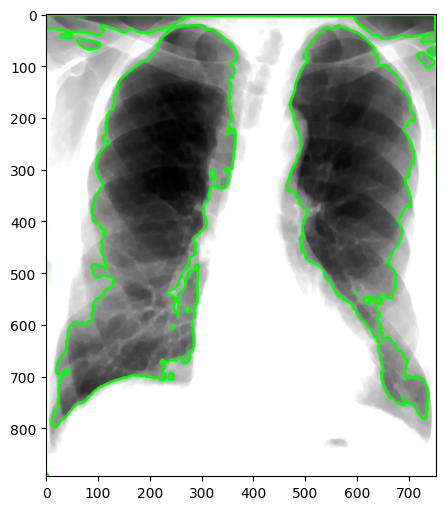

In [2091]:
# contours
def find_contours(image):
    contours, _ = cv2.findContours(image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    # 2 biggest contours
    contours = sorted(contours, key=cv2.contourArea, reverse=True)[:2]
    return contours

def draw_contours(image, contours):
    return cv2.drawContours(image, contours, -1, (0, 255, 0), 3)

contours = find_contours(canny_result)
contour_image = draw_contours(closing, contours)

plt.figure(figsize=(12, 6))
plt.imshow(contour_image)

In [2099]:
# feature extraction using GLCM and plot the results
from skimage.feature import graycomatrix, graycoprops
from skimage import io, color

def glcm_features(image):
    image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    glcm = graycomatrix(image, [1], [0, np.pi/4, np.pi/2, 3*np.pi/4], 256, symmetric=True, normed=True)
    contrast = graycoprops(glcm, prop='contrast')
    dissimilarity = graycoprops(glcm, prop='dissimilarity')
    homogeneity = graycoprops(glcm, prop='homogeneity')
    energy = graycoprops(glcm, prop='energy')
    correlation = graycoprops(glcm, prop='correlation')
    return contrast, dissimilarity, homogeneity, energy, correlation

contrast, dissimilarity, homogeneity, energy, correlation = glcm_features(cropped_top)
print('Contrast:', contrast)
print('Dissimilarity:', dissimilarity)
print('Homogeneity:', homogeneity)
print('Energy:', energy)
print('Correlation:', correlation)


Contrast: [[58.57042065 92.4285791  35.33109416 91.99137725]]
Dissimilarity: [[2.35484323 3.15537938 1.838169   3.13226016]]
Homogeneity: [[0.48626807 0.4375208  0.52365657 0.43863699]]
Energy: [[0.05089885 0.04503408 0.05424711 0.04514084]]
Correlation: [[0.98797016 0.98103005 0.99274231 0.98111978]]
